In [4]:
from scipy import sparse
from bluepysnap import Circuit
from graph_analysis.randomize import WeightPermutedRandomModel
from graph_analysis.rich_cub import RichClubAnalysis
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
file_format = 'png'
dpi = 300

In [3]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_synaptome.npz'
synaptome = sparse.load_npz(adj_path)
connectome = synaptome.copy()
connectome[connectome > 0] = 1
# del synaptome

target = 'slice10'
CIRCUIT_DIR =  '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/sonata/circuit_config.json'
circuit = Circuit(CIRCUIT_DIR)
nodes = circuit.nodes["hippocampus_neurons"]
edges = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical_synapse"]
target_indices = nodes.ids(target)
target_synaptome = synaptome[target_indices,:][:,target_indices]
target_connectome = connectome[target_indices,:][:,target_indices]

In [6]:
model_dp = WeightPermutedRandomModel(target_synaptome)
dp_adj = model_dp.generate(seed=42)

100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


In [9]:
rca_syn = RichClubAnalysis(target_synaptome)
rca_dp = RichClubAnalysis(dp_adj)

<__array_function__ internals>:200: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


In [10]:
rca_syn.total_degree.max() # in this case degree == weight

31232.0

In [11]:
rca_dp.total_degree.max()

23464.0

In [10]:
# max_workers = 8
# cluster = LocalCluster(n_workers=max_workers)

client = Client()    # Start Dask client
k_dict_parallel_model = rca_syn.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
k_dict_parallel_dp = rca_dp.calculate_rich_club_coefficients(weighted=True,
                            method='strongest-links-in-network',step=100)
client.shutdown()    # Shutdown the Dask client

In [11]:
# since keeping weighted degrees are not available yet, lets cap the first N weighted degrees from the minimum shape we have
model_rc_coeffs = pd.DataFrame.from_dict(k_dict_parallel_model.values())
random_rc_coeffs = pd.DataFrame.from_dict(k_dict_parallel_dp.values())

capped_value = min(model_rc_coeffs.values.flatten().shape[0],random_rc_coeffs.values.flatten().shape[0])

In [12]:
capped_value

248

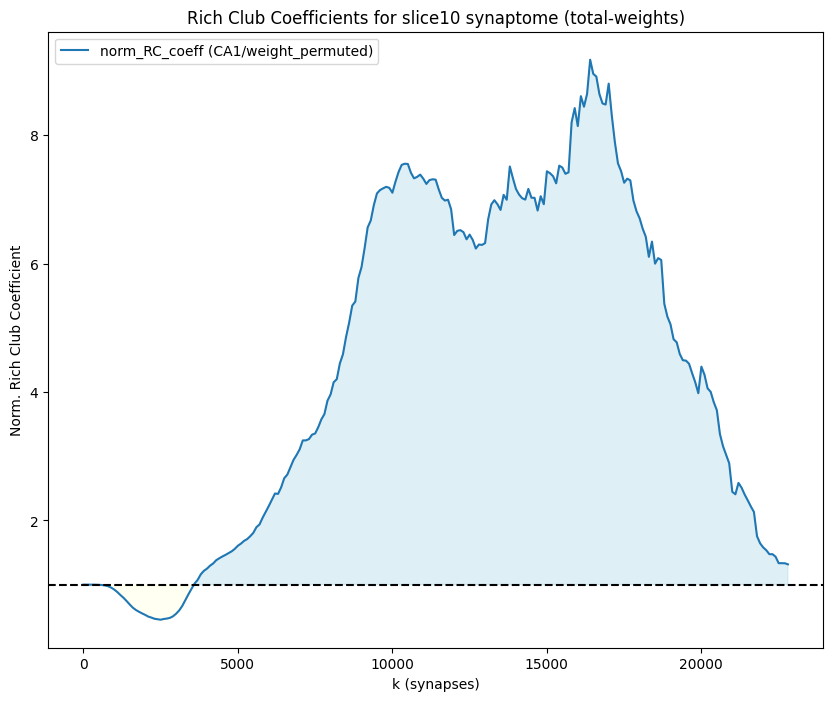

In [15]:
f ,ax= plt.subplots(figsize=(10,8))

orig_values = np.array(list(k_dict_parallel_model.values()))
random_values = np.array(list(k_dict_parallel_dp.values()))
norm_rc = orig_values[:random_values.shape[0]] / random_values
plt.plot(k_dict_parallel_dp.keys(),norm_rc)

ax.fill_between(k_dict_parallel_dp.keys(), norm_rc, 1, where=(np.array(norm_rc) >= 1), color='lightblue',alpha=0.4)
ax.fill_between(k_dict_parallel_dp.keys(), norm_rc, 1, where=(np.array(norm_rc) < 1), color='lightyellow',alpha=0.4)

ax.axhline(y=1, color='k', linestyle='--', label='y=1')


plt.title('Rich Club Coefficients for slice10 synaptome (total-weights)')
plt.xlabel('k (synapses)')
plt.ylabel('Norm. Rich Club Coefficient')
plt.legend(['norm_RC_coeff (CA1/weight_permuted)'])
plt.savefig(f"../output/rich_club_directed_totdegree_weighted.png", dpi=dpi, bbox_inches='tight')

We swapped the weights while preserving the topology of the graph and calculated the rich club coefficient by summing weights in each subgraph (k x k) and dividing by strongest k weights in the whole network (n x n). for original and randomized model. then i calculated normalized rc coeff by dividing original coeff to random coeff.

i see normalized rich club coeff is slightly lower than 1  for k = 0-4000 synapses but after that, its is significantly higher than 1 for up to 24761  incoming + outgoing synapses observed in random model. the original model goes up to 31232 synapses but i capped it to random max weight values for now.

How can i read the norm rich club coeff. it peaks in 3 values 10k and 14k and 16k , then decreases steadily towards 1.2 at 24k synapses.

---------

The rich-club coefficient is a measure used in network science to identify the extent of high-degree nodes forming a 'club' by being more interconnected among themselves compared to lower degree nodes. A high rich-club coefficient indicates that nodes with many connections tend to be more connected to each other, forming a 'rich club'.

When you calculate the normalized rich-club coefficient, you're comparing the rich-club coefficient of your original network to that of a randomized network. If the normalized rich-club coefficient is greater than 1, it means that high-degree nodes in your original network are more densely interconnected than would be expected by chance in a randomized network with the same degree sequence.

In your case, you observe that the normalized rich-club coefficient is slightly lower than 1 for low-degree nodes (k = 0-4000 synapses), but it is significantly higher than 1 for higher-degree nodes. This suggests that, in your network, lower-degree nodes are less interconnected among themselves than expected by chance, but higher-degree nodes are more interconnected among themselves than expected by chance.

You also observe peaks in the normalized rich-club coefficient around 10k, 14k, and 16k synapses. This could mean that there are particularly strong 'clubs' or clusters of interconnected nodes with these degree values in your network.

After 16k, you see the normalized rich-club coefficient decrease steadily towards 1.2 at 24k synapses. This decrease could be interpreted as a diminishing 'rich-club' effect as the degree increases beyond 16k. The rich-club coefficient still remains above 1, indicating that there is still a 'rich-club' effect present, but it's not as pronounced as it is for nodes with around 10k, 14k, and 16k synapses.

Please remember that interpreting the normalized rich-club coefficient in this way assumes that your network and the random networks you're comparing against are representative of the same underlying system. Depending on the specificities of your data and the randomization method used, you might need to adjust this interpretation.

# Next steps

- Repeat for N randomizations and average the results if peaks are conserved or not. 
(N=100) done
- Repeat for other slices, cylinders
- Analyze which mtypes contribute to rich club in general
- Analyze the peaks in normalized RCC and filter mtypes persisting around that weighted region. Perhaps its something other than mtype? i.e. transverse position + mtype?

# Testing the randomization

In [16]:
np.testing.assert_equal(dp_adj.sum(),target_synaptome.sum())

In [17]:
np.testing.assert_array_almost_equal(rca_syn.total_degree,rca_dp.total_degree)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 12609 / 12615 (100%)
Max absolute difference: 16735.
Max relative difference: 1.80432114
 x: array([2330.,  127., 1811., ..., 7371., 6278., 8740.])
 y: array([2288.,  240., 1850., ..., 4464., 4176., 6442.])

In [18]:
dp_connectome = dp_adj.copy()
dp_connectome[dp_connectome>1] = 1

In [19]:
np.testing.assert_equal(target_connectome.max(),dp_connectome.max())

In [20]:
dp_connectome_indegrees = dp_connectome.sum(axis=0).A.flatten()
dp_connectome_outdegrees = dp_connectome.sum(axis=1).A.flatten()
dp_connectome_totaldegrees = dp_connectome_indegrees + dp_connectome_outdegrees

model_connectome_indegrees = target_connectome.sum(axis=0).A.flatten()
model_connectome_outdegrees = target_connectome.sum(axis=1).A.flatten()
model_connectome_totaldegrees = model_connectome_indegrees + model_connectome_outdegrees

In [21]:
np.testing.assert_array_almost_equal(dp_connectome_indegrees.sum(),model_connectome_indegrees.sum())

In [22]:
np.testing.assert_array_almost_equal(dp_connectome_outdegrees.sum(),model_connectome_outdegrees.sum())

In [23]:
np.testing.assert_array_almost_equal(dp_connectome_totaldegrees.sum(),model_connectome_totaldegrees.sum())

In [24]:
np.testing.assert_array_almost_equal(target_connectome.A,dp_connectome.A)